# Import package to manipulate images

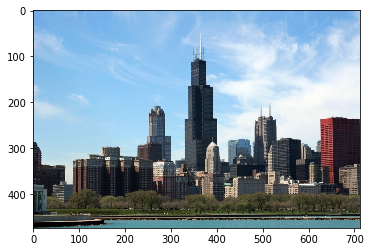

In [3]:
%matplotlib inline
import os
os.chdir('/home/thchoi/maestro/maestro/notebook and backup/img')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('chicago.jpg')
imgplot = plt.imshow(img)

In [4]:
from scipy.misc import imread, imsave, imresize
import keras.backend as K
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


# Read Content Image

In [5]:
content_image = imread('chicago.jpg')
content_image_shape = (content_image.shape[0], content_image.shape[1], content_image.shape[2]) 
e_image_shape = (1,) + content_image_shape #이미지의 갯수를 추가해서 4dimencial numeric한 formant로 바꿈
content_pre = preprocess_input(content_image.reshape(e_image_shape).astype(K.floatx())) # change to vgg16 input format
print('> Loading content image: %s (%dx%d)' % ('chicago.jpg', content_pre.shape[2], content_pre.shape[1]))

> Loading content image: chicago.jpg (712x474)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


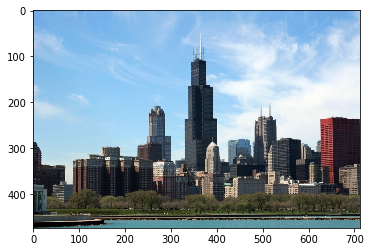

In [6]:
plt.imshow(content_image)

# Read style image and match to content image size 

In [7]:
print('preprocessed content image shape: ' + repr(content_pre.shape))

preprocessed content image shape: (1, 474, 712, 3)


keras와 tensorflow는 batch size = 이미지 갯수를 추가로 다루기 위한 format 사용한다. <br />
이미지를 뭉텅이로 학습시킬때는 커지지만 우리는 1로만 취급한다.

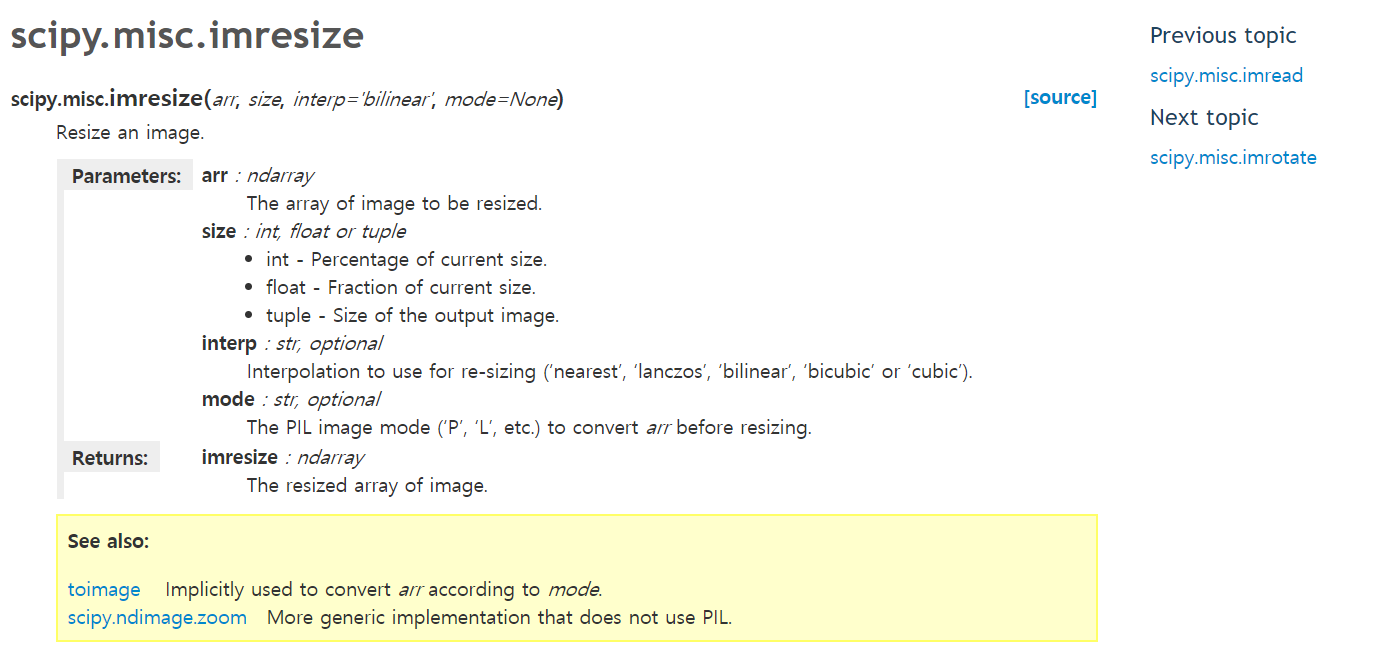

In [8]:
style_image = imread('thescream.jpg')
print('> Loading style image: %s (%dx%d)' % ('thescream.jpg', style_image.shape[1], style_image.shape[0]))
if (style_image.shape[0] != content_pre.shape[1]) or (style_image.shape[1] != content_pre.shape[2]):
    print('> Resizing style image to match content image  size: (%dx%d)' % (content_pre.shape[2], content_pre.shape[1]))
    style_image = imresize(style_image, size=(content_pre.shape[1], content_pre.shape[2]), interp='lanczos')
    style_pre = preprocess_input(style_image.reshape(e_image_shape).astype(K.floatx()))

> Loading style image: thescream.jpg (594x750)
> Resizing style image to match content image  size: (712x474)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


In [9]:
print('raw style image shape' + repr(style_image.shape))
print('preprocessed style_image shape' + repr(style_pre.shape))
print(e_image_shape)

raw style image shape(474, 712, 3)
preprocessed style_image shape(1, 474, 712, 3)
(1, 474, 712, 3)


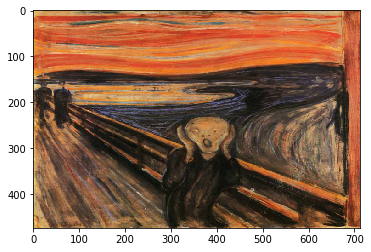

In [10]:
plt.imshow(style_image)

# Build Convolution Neural Network 

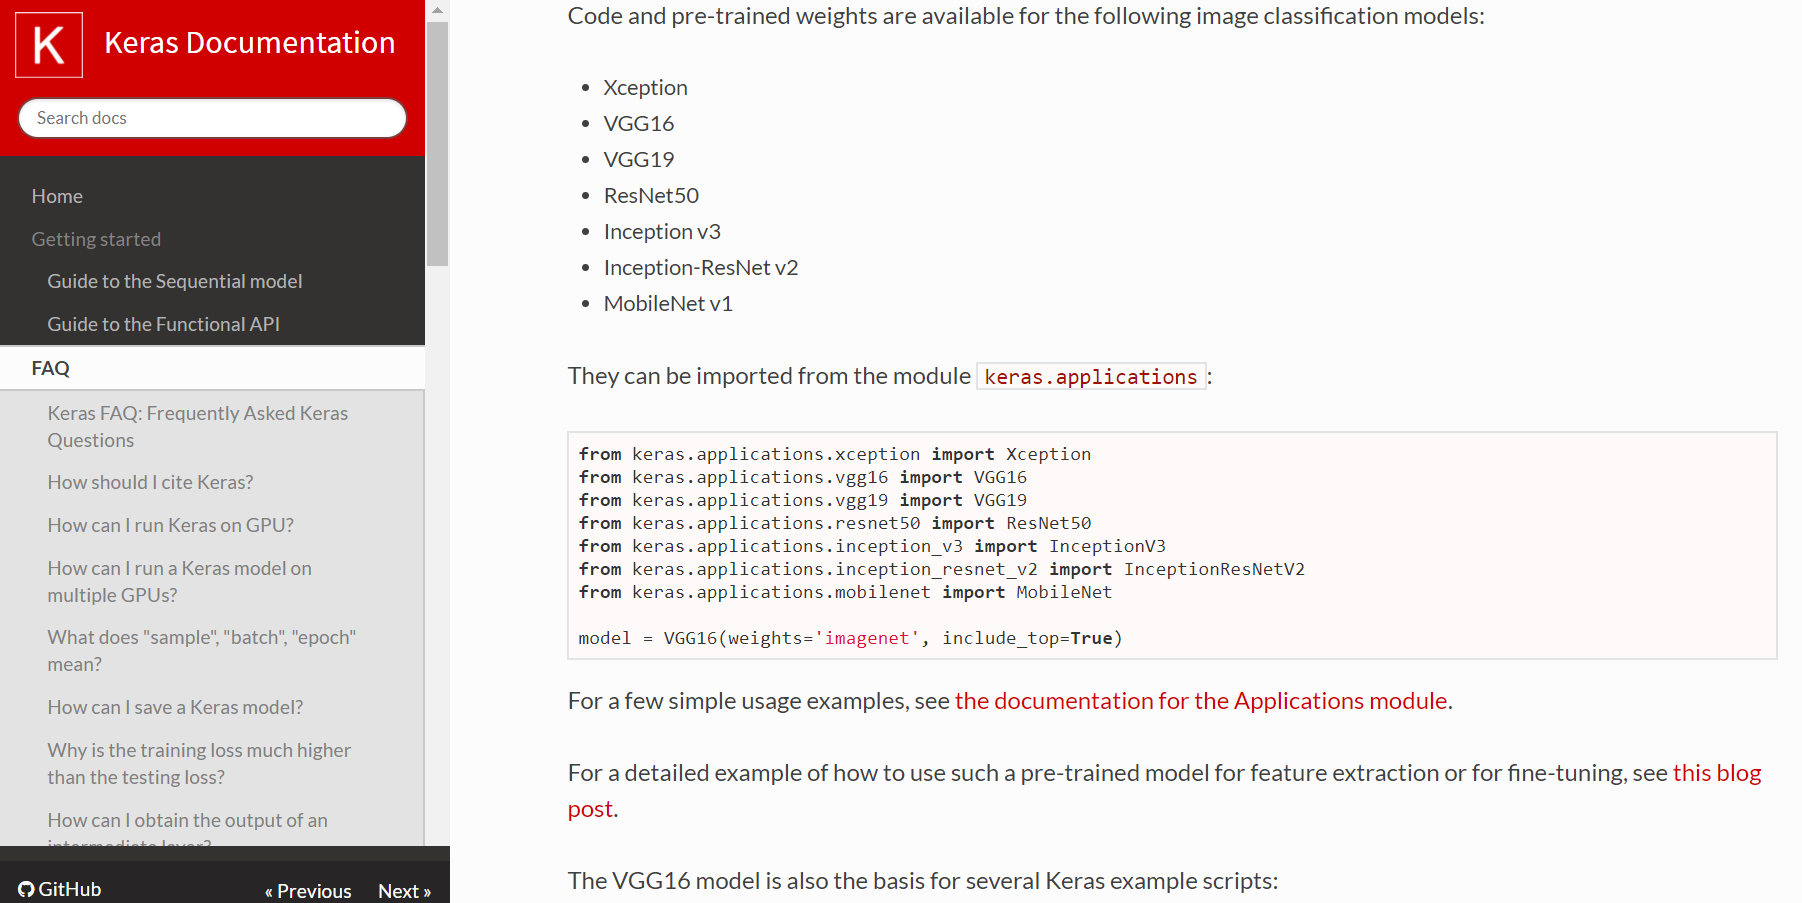

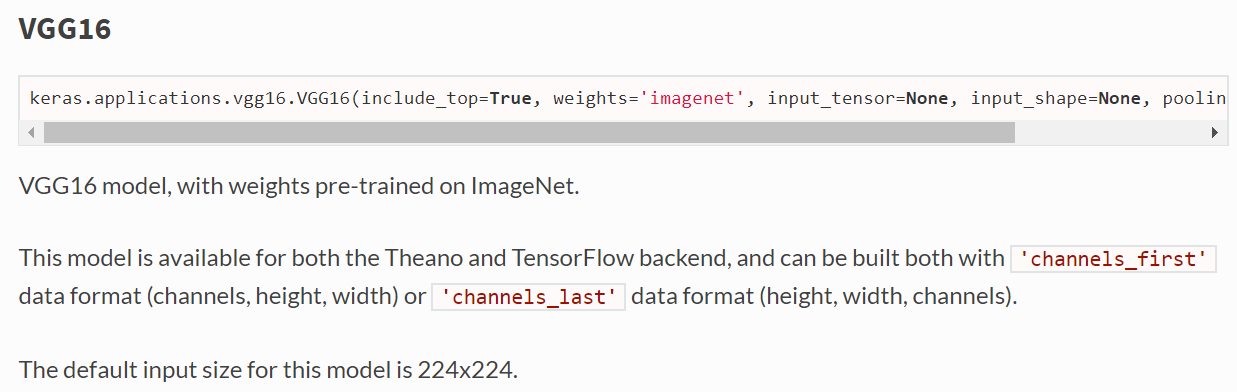

CNN을 사용하는 이유는 image classfication task가 아니고, <br />
각 CNN의 layer별로 나오는 filter responses들을 이용해서 separable하게 reconstruction하는데 목적이 있다. <br />
include_top은 fully connected layer를 사용할 지 말지 선택하는 옵션이다. <br />
나머지 parameter는 default 옵션을 사용해도 괜찮으나, include_top parameter는 false로 바꿔준다. <br />
VGG는 500M가 넘는 무거운 pre-trained-model임을 알아두자

In [11]:
from keras.applications import vgg16
cnn_model = vgg16.VGG16(include_top = False) #not using fully connected layers

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
print(cnn_model.layers)

[<keras.engine.input_layer.InputLayer object at 0x7ff80e8d1cc0>, <keras.layers.convolutional.Conv2D object at 0x7ff80e8d1438>, <keras.layers.convolutional.Conv2D object at 0x7ff80e8c5780>, <keras.layers.pooling.MaxPooling2D object at 0x7ff80e8b7c50>, <keras.layers.convolutional.Conv2D object at 0x7ff80e8b70f0>, <keras.layers.convolutional.Conv2D object at 0x7ff80e03d940>, <keras.layers.pooling.MaxPooling2D object at 0x7ff80e057a20>, <keras.layers.convolutional.Conv2D object at 0x7ff80e057b70>, <keras.layers.convolutional.Conv2D object at 0x7ff80e008c50>, <keras.layers.convolutional.Conv2D object at 0x7ff80dfa1da0>, <keras.layers.pooling.MaxPooling2D object at 0x7ff80dfd1b38>, <keras.layers.convolutional.Conv2D object at 0x7ff80dfd1518>, <keras.layers.convolutional.Conv2D object at 0x7ff80df82400>, <keras.layers.convolutional.Conv2D object at 0x7ff80df20748>, <keras.layers.pooling.MaxPooling2D object at 0x7ff80df501d0>, <keras.layers.convolutional.Conv2D object at 0x7ff80df50748>, <kera

In [16]:
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer = 'block5_conv1'

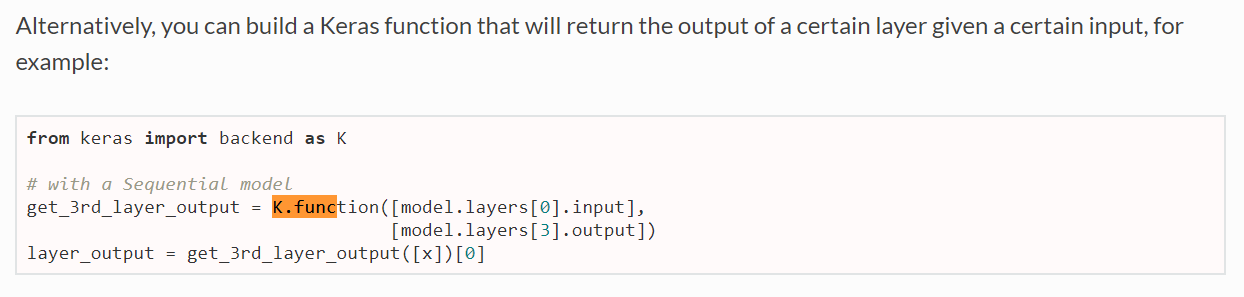
keras에서 cnn모델을 parameter로 ouput을 볼 수 있는 function을 제공한다. <br />
input은 cnn모델의 input layer를 의미한다. <br />
input과 output은 multi-input multi-output이 될 수 있다.

In [17]:
layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'] #layers that to use
get_filters_response = K.function(inputs=[cnn_model.layers[0].input], outputs=[cnn_model.get_layer(t).output for t in layers])

# Get content filter response

In [18]:
content_filters_responses = get_filters_response([content_pre])
print(content_filters_responses)

[array([[[[  0.        ,  97.95239   ,   0.        , ...,   0.        ,
           13.553911  ,   0.        ],
         [  0.        , 137.42012   ,  36.471855  , ...,   0.        ,
          125.99333   ,  57.589077  ],
         [  0.        , 137.3275    ,  35.250095  , ...,   0.        ,
          123.006615  ,  54.539658  ],
         ...,
         [  0.        , 105.3209    ,  44.598732  , ...,   0.        ,
          171.90398   ,  78.547905  ],
         [  0.        , 103.97599   ,  48.021805  , ...,   0.        ,
          185.64034   ,  86.48069   ],
         [  0.        ,  70.65499   , 103.272896  , ...,   0.        ,
          306.73663   , 227.49098   ]],

        [[  0.        , 141.06204   ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  5.322071  , 197.41904   ,  29.132637  , ...,   0.        ,
            3.0335963 ,   0.        ],
         [  2.7782507 , 197.73431   ,  27.999186  , ...,   0.        ,
            0.51552254,   0.    

위의 엄청나게 큰 array를 쉽게 연산할 수 있게하는 data type이 필요로 하다. <br />
keras의 variable의 data type을 이용하면 쉽게 이러한 filter의 reponses들을 다룰 수 있다.

In [19]:
content_representations = K.variable(value=content_filters_responses[layers.index(content_layer)])
print(content_representations)

<tf.Variable 'Variable:0' shape=(1, 29, 44, 512) dtype=float32_ref>


# Get style filters responses

In [20]:
style_filters_responses = get_filters_response([style_pre])
print(style_filters_responses)

[array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           20.934862  ,   0.        ],
         [  0.        ,   0.        ,  46.33487   , ...,   0.        ,
          179.72635   ,  96.75983   ],
         [  0.        ,   0.        ,  40.28268   , ...,   0.        ,
          166.54425   ,  84.09026   ],
         ...,
         [  0.43787453,   0.        ,   0.        , ...,  23.027958  ,
            0.        ,   0.        ],
         [  0.23779574,   0.        ,   0.        , ...,  22.838453  ,
            0.        ,   0.        ],
         [ 15.207337  ,   0.        ,   0.        , ...,  11.61357   ,
            0.        ,   4.470838  ]],

        [[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,  37.73413   , ...,   0.        ,
           39.798603  ,  23.832987  ],
         [  0.        ,   0.        ,  36.69397   , ...,   0.        ,
           51.0612    ,  26.6822

0번째 layer의 모든 filter response를 보면,

In [21]:
style_filters_responses[0]

array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           20.934862  ,   0.        ],
         [  0.        ,   0.        ,  46.33487   , ...,   0.        ,
          179.72635   ,  96.75983   ],
         [  0.        ,   0.        ,  40.28268   , ...,   0.        ,
          166.54425   ,  84.09026   ],
         ...,
         [  0.43787453,   0.        ,   0.        , ...,  23.027958  ,
            0.        ,   0.        ],
         [  0.23779574,   0.        ,   0.        , ...,  22.838453  ,
            0.        ,   0.        ],
         [ 15.207337  ,   0.        ,   0.        , ...,  11.61357   ,
            0.        ,   4.470838  ]],

        [[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,  37.73413   , ...,   0.        ,
           39.798603  ,  23.832987  ],
         [  0.        ,   0.        ,  36.69397   , ...,   0.        ,
           51.0612    ,  26.68221

결국, style picture를 cnn을 거치고 난 response 들을 모아보면 사용하는 style layer가 5개 이므로 똑같이 5개이다.

In [22]:
len(style_filters_responses)

5

먼저 K.variable 데이터 타입으로 만들기 전에, <br />
style에 대한 loss를 정의하기 위해 style이라는 것은 filter response들의 correlation로 정의한다는 것을 잊으면 안된다.
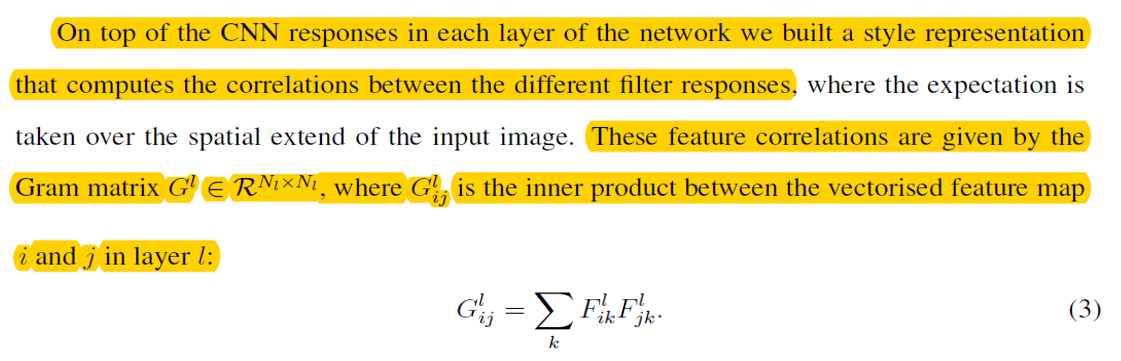

Gram matrix는 결국 한 Convolution layer 안에 있는 모든 feature vetor들의 내적이다.

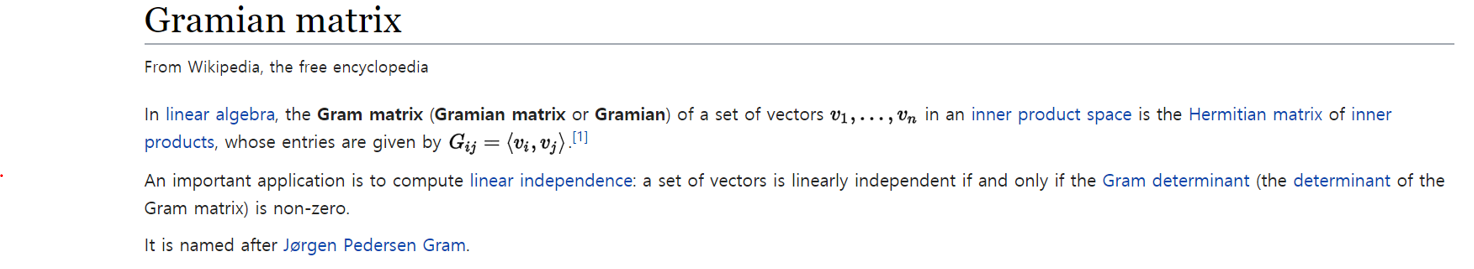

In [23]:
def gram_matrix(filters):
    c_filters = K.batch_flatten(K.permute_dimensions(K.squeeze(filters, axis=0), pattern=(2, 0, 1)))
    return K.dot(c_filters, K.transpose(c_filters))

In [24]:
style_representations = [gram_matrix(o) for o in style_filters_responses] #style representation define by filters correlation
print(style_representations)

[<tf.Tensor 'MatMul:0' shape=(64, 64) dtype=float32>, <tf.Tensor 'MatMul_1:0' shape=(128, 128) dtype=float32>, <tf.Tensor 'MatMul_2:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'MatMul_3:0' shape=(512, 512) dtype=float32>, <tf.Tensor 'MatMul_4:0' shape=(512, 512) dtype=float32>]


# Define Content loss function

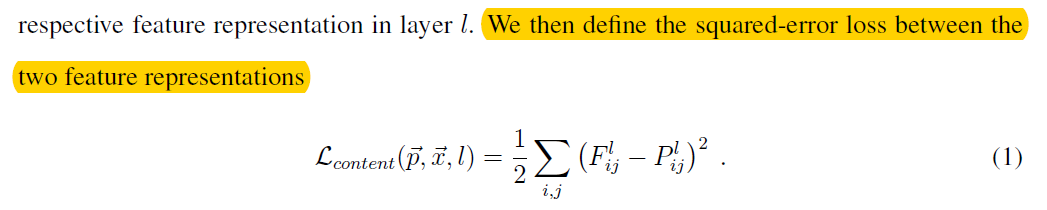

In [25]:
content_loss_function = 0.5 * K.sum(K.square(content_representations - cnn_model.get_layer(content_layer).output))
print('> Complete define content loss function')

> Complete define content loss function


In [26]:
print(content_loss_function)

Tensor("mul:0", shape=(), dtype=float32)


# Define style loss function

논문의 저자는 <br />
어떤 random 하게 noise이미지의 gram matrix와 사용자가 처음에 넣엇던 스타일 이미지의 gram matrix와의 차이의 square하고 K.sum하고, <br />
N은 l번째 layer의 filter의 갯수이고, M은 l번째 layer의 activation map의 가로세로를 곱한 사이즈 값을 의미한다. <br />
style_filters_responses의 keras의 preprocessing_input을 거친 variable이므로 shape에 fitler 갯수와 activation map의 사이즈를 가지고 있다.

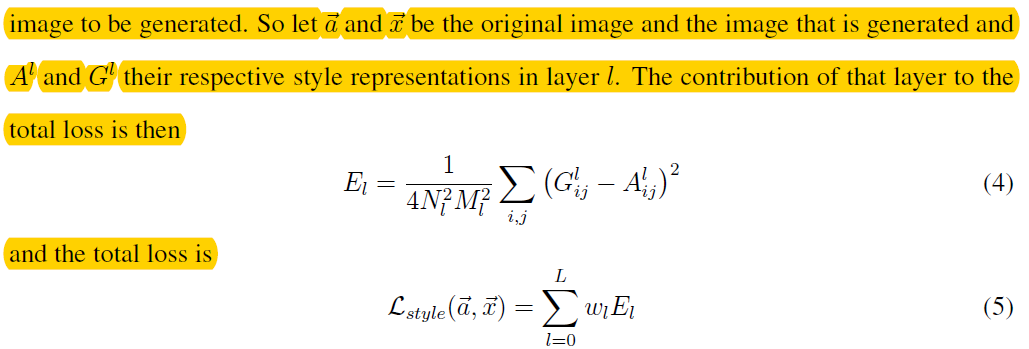

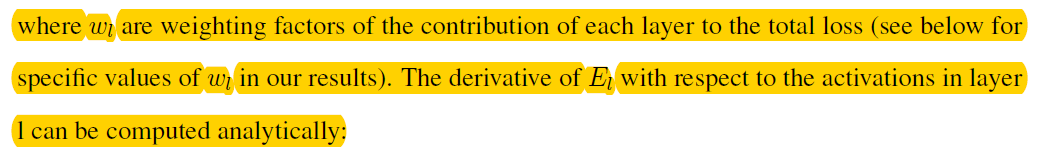

먼저 style loss를 정의하기 위해 <br />
style loss function은 content loss loss는 El 수식에 각 사용할 레이어에 weight를 주어서 정의된다. <br />
weight는 style을 추출할 때 어떤 layer를 사용하면 weight를 주고, 사용하지 않는 layer들은 0을 준다. <br />
weight들의 sum은 1이다.

In [27]:
style_loss_function = 0.0
style_loss_function_weight = 1.0 / float(len(style_layers))

각 레이어의 N, M 을 살펴보자

In [28]:
print(style_filters_responses[0].shape)

(1, 474, 712, 64)


474는 filter response = activation map의 세로
712는 activation map의 세로
64는 필터의 갯수를 의미한다.
따라서, activation map size는 style_filters_responses[0].shape[1] * style_filters_responses[0].shape[2] 이고
filter의 갯수는 style_filters_responses[0].shape[3] 이다.

In [29]:
print('0_layer activation map size is ' + str(style_filters_responses[0].shape[1]*style_filters_responses[0].shape[2]))
print('0_layer filter number is ' + str(style_filters_responses[0].shape[3]))

0_layer activation map size is 337488
0_layer filter number is 64


In [30]:
print('1_layer activation map size is ' + str(style_filters_responses[1].shape[1]*style_filters_responses[0].shape[2]))
print('1_layer filter number is ' + str(style_filters_responses[1].shape[3]))

1_layer activation map size is 168744
1_layer filter number is 128


In [31]:
print('2_layer activation map size is ' + str(style_filters_responses[2].shape[1]*style_filters_responses[0].shape[2]))
print('2_layer filter number is ' + str(style_filters_responses[2].shape[3]))

2_layer activation map size is 84016
2_layer filter number is 256


In [32]:
style_representations[0]

<tf.Tensor 'MatMul:0' shape=(64, 64) dtype=float32>

In [33]:
gram_matrix(cnn_model.get_layer(style_layers[0]).output)

<tf.Tensor 'MatMul_5:0' shape=(?, ?) dtype=float32>

 N은 l번째 layer의 filter의 갯수이고, M은 l번째 layer의 activation map의 가로세로를 곱한 사이즈 값을 의미

In [34]:
for i, style_layer in enumerate(style_layers):
    N = style_filters_responses[i].shape[3]
    M = style_filters_responses[i].shape[1] * style_filters_responses[i].shape[2] 
    style_loss_function += (style_loss_function_weight *
    (1.0 / (4.0 * (N ** 2.0) * (M ** 2.0))) * K.sum(K.square(style_representations[i] - gram_matrix(cnn_model.get_layer(style_layer).output))))
print('> Complete define style loss function')

> Complete define style loss function


In [35]:
print(style_loss_function)

Tensor("add_4:0", shape=(), dtype=float32)


# Define Total loss function

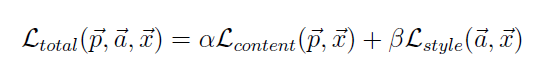
total loss는 content loss function과 style loss function의 특정한 weight들을 준 sum으로 정의하고있다.

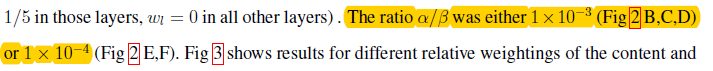
논문에서는 style weight을 content weight보다 천 배에서 만 배로 테스트하였다.
먼저, 천배정도로 둬보자

In [36]:
alpha_content = 0.001
beta_style = 1

위의 값들은 output이 style을 강조할지 content를 강조할지 결정하는 weight이다.
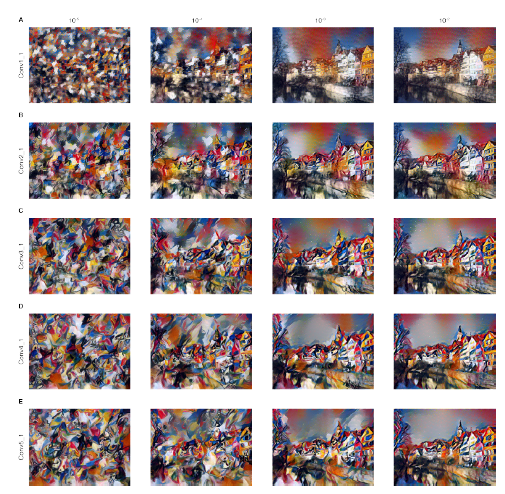
논문의 저자는 layer를 더 많이 사용할수록, style을 강조한다고 추가로 말하고있다.

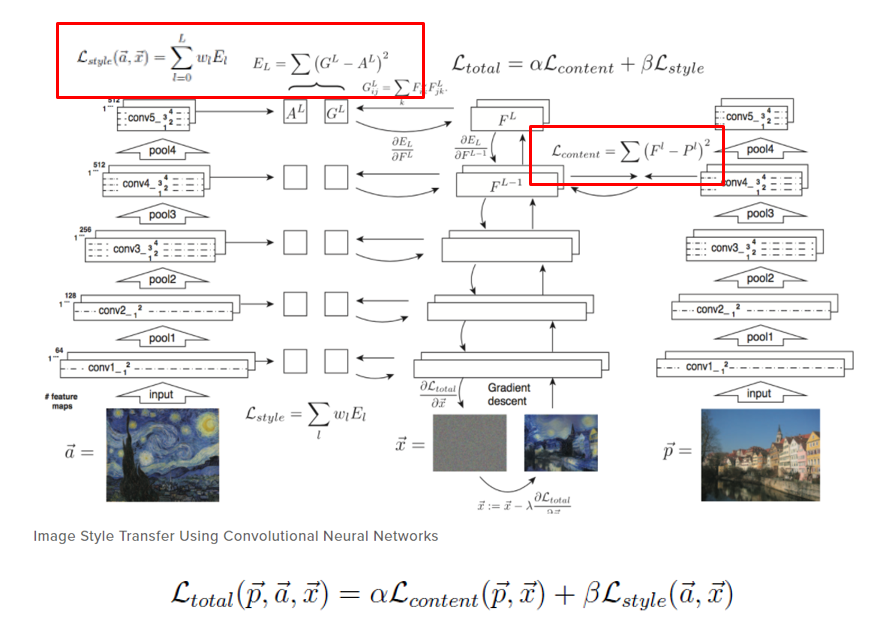
gradients descent를 적용하기 위한 사용할 layer를 지정해주고 output은 total loss식을 지정 <br/>
k.function에서 사용할 layer를 지정해주면, <br/>
원래 content loss function과 style loss function에서 get_layer로 해당하는 layer만 추린 함수 꼴이 될것이다.

In [37]:
total_loss = (alpha_content * content_loss_function) + (beta_style * style_loss_function)
cnn_inputs = [cnn_model.get_layer(l).output for l in layers]
cnn_inputs.append(cnn_model.layers[0].input)
total_loss_function = K.function(inputs=cnn_inputs, outputs=[total_loss])
print('> Complete define total loss function')

> Complete define total loss function


keras에서 gradient tensors를 리턴하는 gradient method를 제공한다.

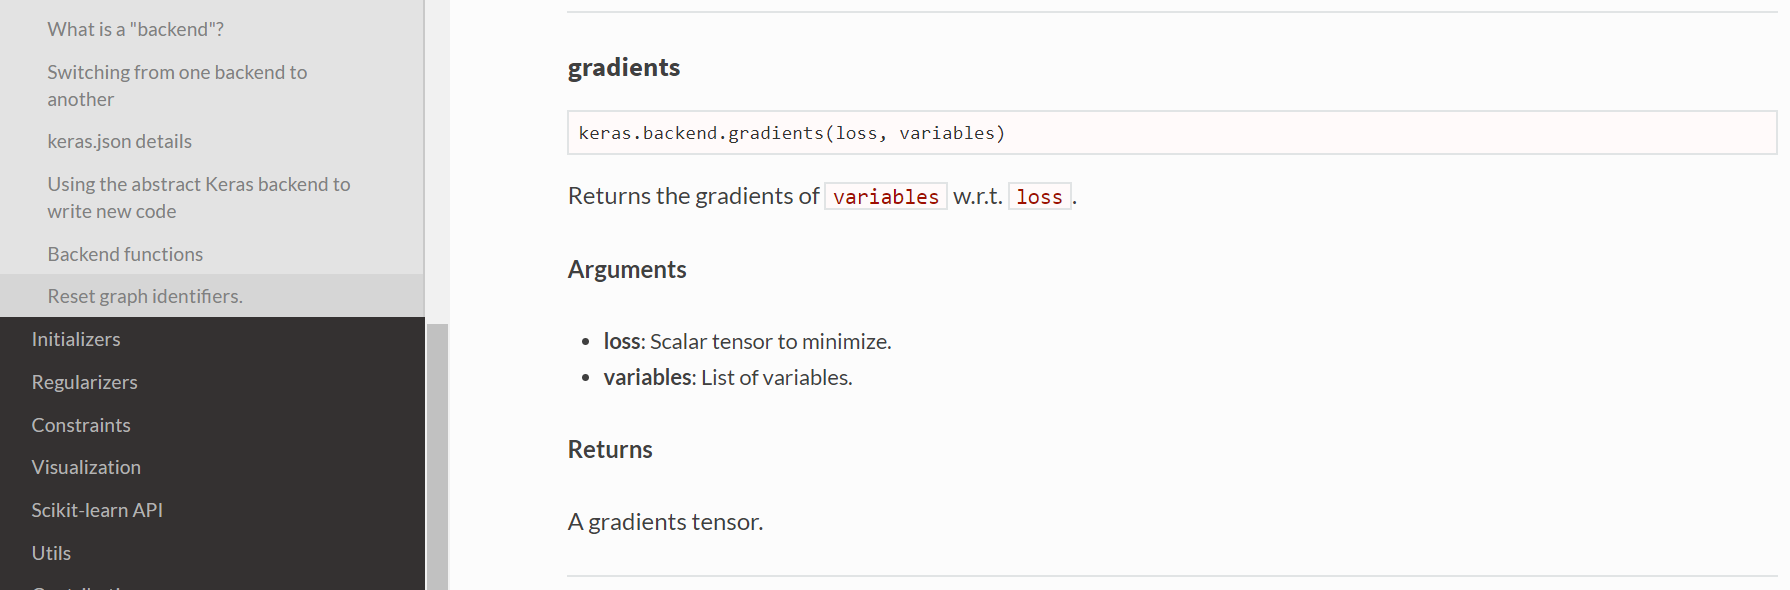

주어진 total_loss식을 타겟으로 두고, gradient를 찾는 function pointer를 생성한다. <br />

In [38]:
loss_gradient = K.gradients(loss=total_loss, variables=[cnn_model.layers[0].input])
print(loss_gradient)
loss_function_gradient = K.function(inputs=[cnn_model.layers[0].input], outputs=loss_gradient)
print('> Complete define loss gradient function')
print(loss_function_gradient)

[<tf.Tensor 'gradients/block1_conv1/convolution_grad/Conv2DBackpropInput:0' shape=(?, ?, ?, 3) dtype=float32>]
> Complete define loss gradient function


# Make noise image based content image to style transfer

먼저 후처리로 preprocessing된 이미지를 복원해서 노트북으로 띄워보자

In [39]:
noise_image = content_pre.copy()

postprcessing 과정은 pre process의 반대 과정이다.
preprocessing method to use vgg16
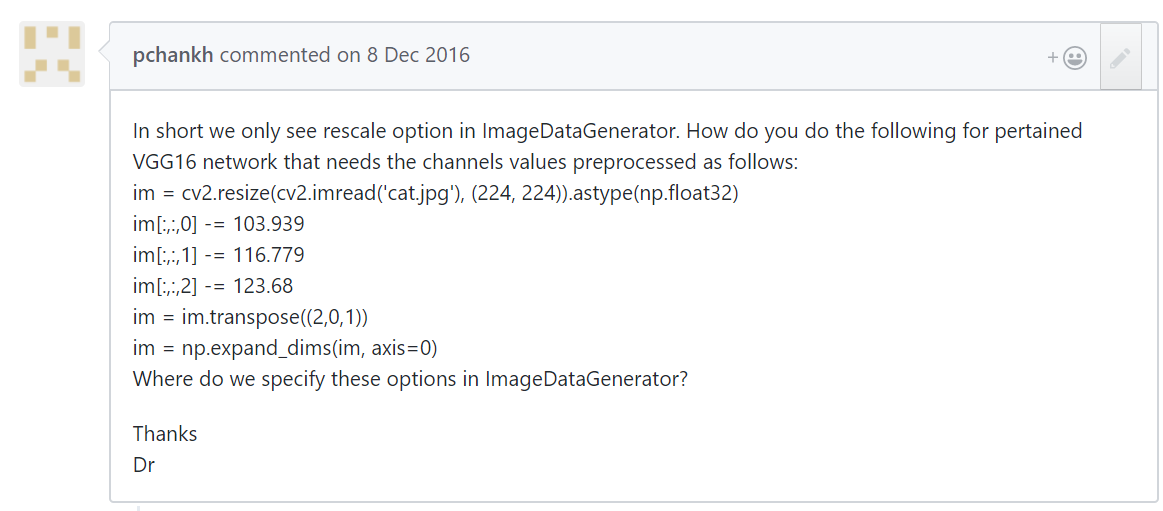

In [40]:
import numpy as np

def postprocessing_img(image):
    image[:, :, :, 0] += 103.939 #hyper-parameter
    image[:, :, :, 1] += 116.779 #hyper-parameter
    image[:, :, :, 2] += 123.68  #hyper-parameter
    return np.clip(image[:, :, :, ::-1], 0, 255).astype('uint8')[0]

위의 함수가 vgg16에서 사용하는 postprocessing method인데, <br />
한번 임의의 값을 바꿔보자, RGB의 값을 조정할것으로 예상된다.

In [41]:
def my_postprocessing_img(image):
    image[:, :, :, 0] += 63.939 #hyper-parameter
    image[:, :, :, 1] += 96.779 #hyper-parameter
    image[:, :, :, 2] += 323.68  #hyper-parameter
    return np.clip(image[:, :, :, ::-1], 0, 255).astype('uint8')[0]

In [42]:
noise_pro = postprocessing_img(noise_image.reshape(e_image_shape).copy())

content 전처리이미지를 복사한 noise image를 두가지 후처리 method를 적용시켜보면

In [43]:
imsave('kkk.jpg', postprocessing_img(noise_image.reshape(e_image_shape).copy()))
imsave('jjj.jpg', my_postprocessing_img(noise_image.reshape(e_image_shape).copy()))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


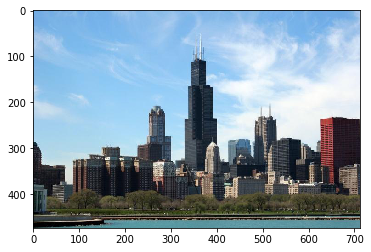

In [44]:
plt.imshow(imread('kkk.jpg'))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


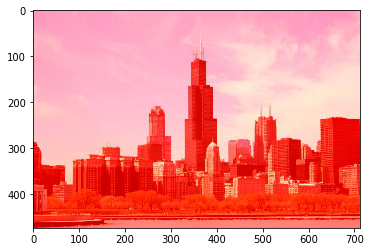

In [45]:
plt.imshow(imread('jjj.jpg'))

위의 결과는 좋게 바뀌진 않았지만,<br />
output을 나오게 할때 postprocessing method를 조정하는것도 hyper-parameter가 될 수 있을것이다.

# Optimization

tensorflow나 keras에서도 optimize하는 class나 method들을 제공하지만,  <br>
scipy.optimize에서는 수십가지의 optimization method들을 지원한다. <br>
scipy.optimize에서 사용할 수 있는 optimization method들이다. <br>
deafult는 'CG method'이다.<br>
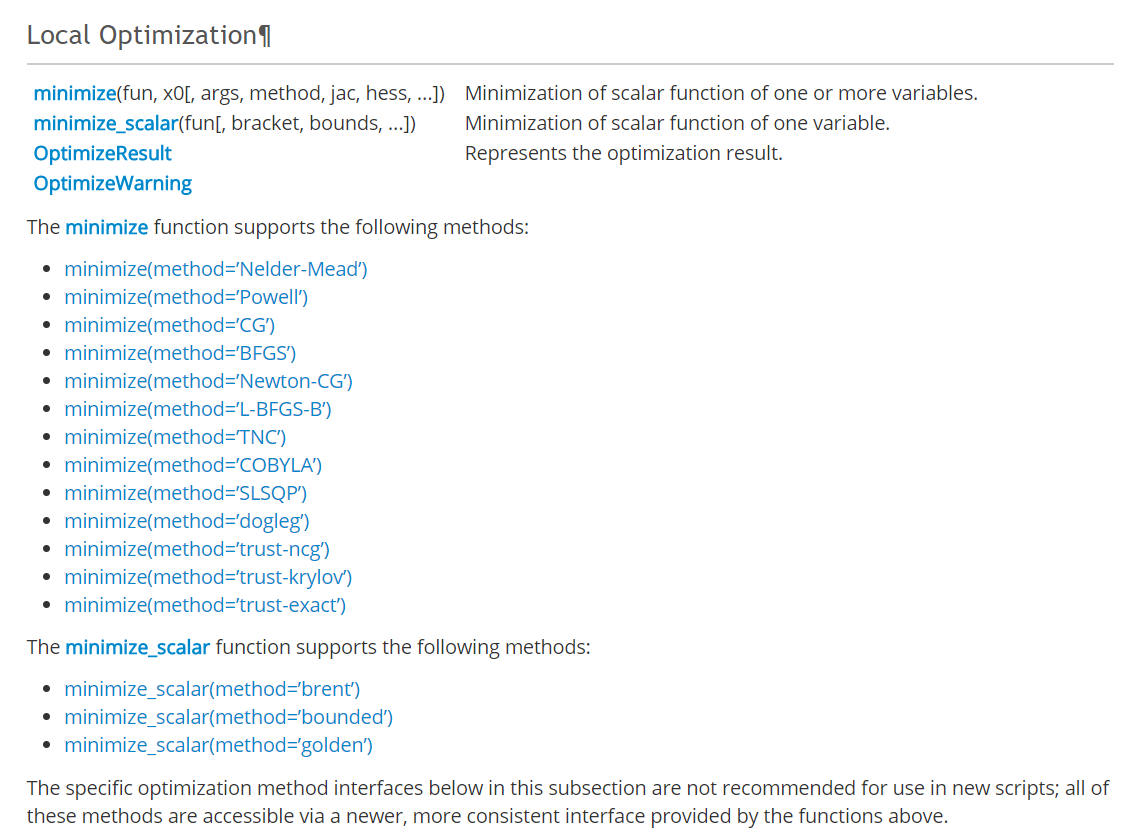

In [46]:
from scipy.optimize import minimize
optimization_method = 'CG' 
iterations, iteration = 100, 0

scipy.optimize의 minize method는 <br>
noise이미지와 loss function pointer, gradient function pointer, 와 optimization method string을 argument로 동작한다.

순차적으로 연결한 function pointer들을 연결지어 생각해 보았을때,  <br>
noise로부터 style loss function과 content loss function가 더해진 total loss function의 gradient을 찾아  <br>
n차원의 곡선의 최소값의 세타를 찾아 이를 최소화 -> 비슷한 구조가 되도록 연산할 것이다.  <br>

In [49]:
def loss(image):
    #e_image_shape = (1, 474, 712, 3)
    outputs = get_filters_response([image.reshape(e_image_shape).astype(K.floatx())])
    outputs.append(image.reshape(e_image_shape).astype(K.floatx()))
    loss = total_loss_function(outputs)[0]
    print('Loss: %.2f' % loss)
    return loss

In [50]:
def loss_gradient(image):
    #e_image_shape = (1, 474, 712, 3)
    return np.array(loss_function_gradient([image.reshape(e_image_shape).astype(K.floatx())])).astype('float64').flatten()

In [51]:
def callback(image):
    global iteration
    iteration += 1
    if iteration == iterations + 1:
        print('Complete style transfer')
        
    noise_image = image.copy()
    print('Optimization step: %d/%d' % (iteration, iterations))
    save_image(image)

In [52]:
def save_image(image):
    imsave('noise' + str(iteration) + '.jpg', postprocessing_img(image.reshape(e_image_shape).copy()))

In [53]:
def optimize():
    print('> Starting optimazation with %s method' %optimization_method)
    minimize(fun=loss, x0=noise_image.flatten(), jac=loss_gradient, callback= callback, method=optimization_method)

In [54]:
optimize()

> Starting optimazation with CG method
Loss: 230062224.00
Loss: 229987600.00
Loss: 229689488.00
Loss: 228503920.00
Loss: 223871936.00
Loss: 207168736.00
Loss: 164731968.00
Optimization step: 1/100
Loss: 101004400.00


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Optimization step: 2/100
Loss: 110553816.00
Loss: 76510472.00
Optimization step: 3/100
Loss: 67088168.00
Loss: 63074220.00
Optimization step: 4/100
Loss: 54813856.00
Optimization step: 5/100
Loss: 46044356.00
Optimization step: 6/100
Loss: 41959768.00
Optimization step: 7/100
Loss: 38006404.00
Optimization step: 8/100
Loss: 35800632.00
Optimization step: 9/100
Loss: 32494738.00
Loss: 31543470.00
Optimization step: 10/100
Loss: 27576836.00
Optimization step: 11/100
Loss: 24994244.00
Optimization step: 12/100
Loss: 24450734.00
Loss: 23414818.00
Optimization step: 13/100
Loss: 21968574.00
Optimization step: 14/100
Loss: 20349016.00
Optimization step: 15/100
Loss: 19180602.00
Optimization step: 16/100
Loss: 20372912.00
Loss: 18801790.00
Optimization step: 17/100
Loss: 18130186.00
Loss: 17098770.00
Optimization step: 18/100
Loss: 17840908.00
Loss: 16403669.00
Optimization step: 19/100
Loss: 15397994.00
Loss: 15091375.00
Optimization step: 20/100
Loss: 13996383.00
Optimization step: 21/100
L

KeyboardInterrupt: 

결과를 순차적으로 가상환경에서 만들어진 noise이미지가 어떻게 바뀌었는지 확인해보자.  <br>

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


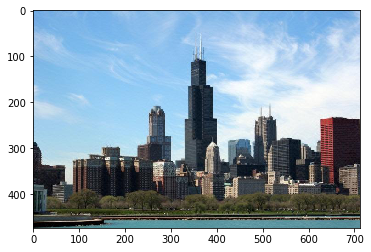

In [56]:
plt.imshow(imread('noise' + str(1) + '.jpg'))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


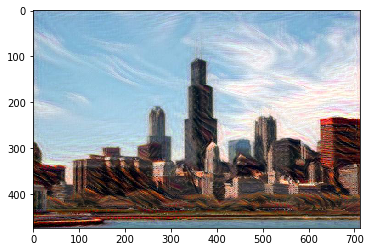

In [57]:
plt.imshow(imread('noise' + str(20) + '.jpg'))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


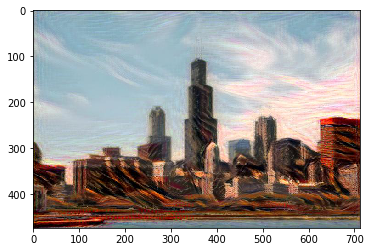

In [58]:
plt.imshow(imread('noise' + str(50) + '.jpg'))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


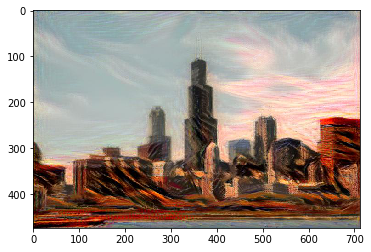

In [59]:
plt.imshow(imread('noise' + str(100) + '.jpg'))